### Exercise 0

In [1]:
import site
site.getsitepackages()

['/usr/local/Cellar/python/3.7.4/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages']

### Exercise 1.1

In [2]:
import nltk
import pprint
from nltk.corpus import conll2000
print(conll2000.chunked_sents('train.txt')[99])

(S
  (PP Over/IN)
  (NP a/DT cup/NN)
  (PP of/IN)
  (NP coffee/NN)
  ,/,
  (NP Mr./NNP Stone/NNP)
  (VP told/VBD)
  (NP his/PRP$ story/NN)
  ./.)


In [3]:
print(conll2000.chunked_sents('train.txt', chunk_types=['NP'])[99])

(S
  Over/IN
  (NP a/DT cup/NN)
  of/IN
  (NP coffee/NN)
  ,/,
  (NP Mr./NNP Stone/NNP)
  told/VBD
  (NP his/PRP$ story/NN)
  ./.)


In [4]:
nltk.chunk.tree2conlltags(conll2000.chunked_sents('train.txt')[99])

[('Over', 'IN', 'B-PP'),
 ('a', 'DT', 'B-NP'),
 ('cup', 'NN', 'I-NP'),
 ('of', 'IN', 'B-PP'),
 ('coffee', 'NN', 'B-NP'),
 (',', ',', 'O'),
 ('Mr.', 'NNP', 'B-NP'),
 ('Stone', 'NNP', 'I-NP'),
 ('told', 'VBD', 'B-VP'),
 ('his', 'PRP$', 'B-NP'),
 ('story', 'NN', 'I-NP'),
 ('.', '.', 'O')]

In [5]:
dev_set = conll2000.chunked_sents('train.txt', chunk_types=['NP'])
print(len(dev_set))
dev_train = dev_set[:-1000]
dev_test = dev_set[-1000:]

8936


### Exercise 1.2

In [6]:
class UnigramChunker(nltk.ChunkParserI):
    def __init__(self, train_sents):
        train_data = [[(t,c) for w,t,c in nltk.chunk.tree2conlltags(sent)]
            for sent in train_sents]
        self.tagger = nltk.UnigramTagger(train_data)
        
    def parse(self, sentence):
        pos_tags = [pos for (word,pos) in sentence]
        tagged_pos_tags = self.tagger.tag(pos_tags)
        chunktags = [chunktag
                     for (pos, chunktag) in tagged_pos_tags]
        conlltags = [(word, pos, chunktag)
                     for ((word,pos),chunktag)
                     in zip(sentence, chunktags)]
        return nltk.chunk.conlltags2tree(conlltags)

In [7]:
unigram_chunker = UnigramChunker(dev_train)
print(unigram_chunker.evaluate(dev_test))

ChunkParse score:
    IOB Accuracy:  92.7%%
    Precision:     78.9%%
    Recall:        85.2%%
    F-Measure:     81.9%%


### Exercise 1.3

In [8]:
def npchunk_features_0(sentence, i, history):
    word, pos = sentence[i]
    return {"pos": pos}

In [9]:
class ConsecutiveTagger(nltk.TaggerI):
    def __init__(self, train_sents, features=npchunk_features_0, learner=nltk.NaiveBayesClassifier):
        self.features = features
        train_set = []
        for tagged_sent in train_sents:
            untagged_sent = nltk.tag.untag(tagged_sent)
            history = []
            for i, (word, tag) in enumerate(tagged_sent):
                featureset = features(untagged_sent, i, history)
                train_set.append( (featureset, tag) )
                history.append(tag)
        self.classifier = learner.train(train_set)
    
    def tag(self, sentence):
        history = []
        for i, word in enumerate(sentence):
            featureset = self.features(sentence, i, history)
            tag = self.classifier.classify(featureset)
            history.append(tag)
        return zip(sentence, history)

In [10]:
class Chunker(nltk.ChunkParserI):
    def __init__(self, train_sents,
        tagger=ConsecutiveTagger, **kwargs):
        tagged_sents = [[((w,t),c)
                        for (w,t,c) in nltk.chunk.tree2conlltags(sent)]
                        for sent in train_sents]
        self.tagger = tagger(tagged_sents, **kwargs)
        
    def parse(self, sentence):
        tagged_sents = self.tagger.tag(sentence)
        conlltags = [(w,t,c) for ((w,t),c) in tagged_sents]
        return nltk.chunk.conlltags2tree(conlltags)

In [11]:
chunker_0 = Chunker(dev_train, features=npchunk_features_0)
score_0 = chunker_0.evaluate(dev_test)
print(score_0)

ChunkParse score:
    IOB Accuracy:  92.7%%
    Precision:     78.9%%
    Recall:        85.2%%
    F-Measure:     81.9%%


In [12]:
score_0.f_measure()

0.8189038295195408

### Exercise 1.4

In [13]:
def npchunk_features_1(sentence, i, history):
    word, pos = sentence[i]
    if i == 0:
        prevword, prevpos = "<START>", "<START>"
    else:
        prevword, prevpos = sentence[i-1]
        
    return {"pos": pos, "prevpos": prevpos}

def npchunk_features_2(sentence, i, history):
    word, pos = sentence[i]
    
    if i == 0:
        prevword, prevpos = "<START>", "<START>"
    else:
        prevword, prevpos = sentence[i-1]
        
    return {"pos": pos, "word": word, "prevpos": prevpos}

def npchunk_features_3(sentence, i, history):
    word, pos = sentence[i]
    if i == 0:
        prevword, prevpos = "<START>", "<START>"
    else:
        prevword, prevpos = sentence[i-1]
    
    if i == len(sentence)-1:
        nextword, nextpos = "<END>", "<END>"
    else:
        nextword, nextpos = sentence[i+1]
    
    return {"pos": pos,
            "word": word,
            "prevpos": prevpos,
            "nextpos": nextpos, 
            "prevpos+pos": "%s+%s" % (prevpos, pos),
            "pos+nextpos": "%s+%s" % (pos, nextpos),
            "tags-since-dt": tags_since_dt(sentence, i)} 

In [14]:
def tags_since_dt(sentence, i):
     tags = set()
     for word, pos in sentence[:i]:
         if pos == 'DT':
             tags = set()
         else:
             tags.add(pos)
     return '+'.join(sorted(tags))

In [15]:
%%time
chunker_0 = Chunker(dev_train, features=npchunk_features_0)
score_0 = chunker_0.evaluate(dev_test)
print("feature 0: \n", score_0)
print(score_0.f_measure())

chunker_1 = Chunker(dev_train, features=npchunk_features_1)
score_1 = chunker_1.evaluate(dev_test)
print("feature 1: \n", score_1)
print(score_1.f_measure())


chunker_2 = Chunker(dev_train, features=npchunk_features_2)
score_2 = chunker_2.evaluate(dev_test)
print("feature 2: \n", score_2)
print(score_2.f_measure())


chunker_3 = Chunker(dev_train, features=npchunk_features_3)
score_3 = chunker_3.evaluate(dev_test)
print("feature 3: \n", score_3)
print(score_3.f_measure())

feature 0: 
 ChunkParse score:
    IOB Accuracy:  92.7%%
    Precision:     78.9%%
    Recall:        85.2%%
    F-Measure:     81.9%%
0.8189038295195408
feature 1: 
 ChunkParse score:
    IOB Accuracy:  93.3%%
    Precision:     80.6%%
    Recall:        86.8%%
    F-Measure:     83.6%%
0.8359571788413097
feature 2: 
 ChunkParse score:
    IOB Accuracy:  94.1%%
    Precision:     83.0%%
    Recall:        88.4%%
    F-Measure:     85.6%%
0.8557852221430268
feature 3: 
 ChunkParse score:
    IOB Accuracy:  94.7%%
    Precision:     84.7%%
    Recall:        88.8%%
    F-Measure:     86.7%%
0.8674756506466549
CPU times: user 17.4 s, sys: 438 ms, total: 17.8 s
Wall time: 18.9 s


### Exercise 2.1

In [16]:
def npchunk_features_00(sentence, i, history):
    word, pos = sentence[i]
    return {"pos": pos,
            "predTag": history[-1] if len(history)>0 else ""}

def npchunk_features_01(sentence, i, history):
    word, pos = sentence[i]
    if i == 0:
        prevword, prevpos = "<START>", "<START>"
    else:
        prevword, prevpos = sentence[i-1]
        
    return {"pos": pos, "prevpos": prevpos,
            "predTag": history[-1] if len(history)>0 else ""}

def npchunk_features_02(sentence, i, history):
    word, pos = sentence[i]
    
    if i == 0:
        prevword, prevpos = "<START>", "<START>"
    else:
        prevword, prevpos = sentence[i-1]
        
    return {"pos": pos, "word": word, "prevpos": prevpos,
            "predTag": history[-1] if len(history)>0 else ""}

def npchunk_features_03(sentence, i, history):
    word, pos = sentence[i]
    
    if i == 0:
        prevword, prevpos = "<START>", "<START>"
    else:
        prevword, prevpos = sentence[i-1]
    
    if i == len(sentence)-1:
        nextword, nextpos = "<END>", "<END>"
    else:
        nextword, nextpos = sentence[i+1]
    
    return {"pos": pos,
            "word": word,
            "prevpos": prevpos,
            "nextpos": nextpos, 
            "prevpos+pos": "%s+%s" % (prevpos, pos),
            "pos+nextpos": "%s+%s" % (pos, nextpos),
            "tags-since-dt": tags_since_dt(sentence, i),
            "predTag": history[-1] if len(history)>0 else ""} 

In [17]:
%%time
chunker_00 = Chunker(dev_train, features=npchunk_features_00)
score_00 = chunker_00.evaluate(dev_test)
print("feature 00: \n", score_00)
print(score_00.f_measure())

chunker_01 = Chunker(dev_train, features=npchunk_features_01)
score_01 = chunker_01.evaluate(dev_test)
print("feature 01: \n", score_01)
print(score_01.f_measure())


chunker_02 = Chunker(dev_train, features=npchunk_features_02)
score_02 = chunker_02.evaluate(dev_test)
print("feature 02: \n", score_02)
print(score_02.f_measure())


chunker_03 = Chunker(dev_train, features=npchunk_features_03)
score_03 = chunker_03.evaluate(dev_test)
print("feature 03: \n", score_03)
print(score_03.f_measure())

feature 00: 
 ChunkParse score:
    IOB Accuracy:  93.0%%
    Precision:     80.8%%
    Recall:        85.1%%
    F-Measure:     82.9%%
0.8290312300828552
feature 01: 
 ChunkParse score:
    IOB Accuracy:  92.6%%
    Precision:     79.4%%
    Recall:        83.0%%
    F-Measure:     81.2%%
0.811575665520825
feature 02: 
 ChunkParse score:
    IOB Accuracy:  94.3%%
    Precision:     83.6%%
    Recall:        88.0%%
    F-Measure:     85.7%%
0.8574386747371775
feature 03: 
 ChunkParse score:
    IOB Accuracy:  94.8%%
    Precision:     85.5%%
    Recall:        88.1%%
    F-Measure:     86.8%%
0.8678151666398326
CPU times: user 19.2 s, sys: 248 ms, total: 19.4 s
Wall time: 20.4 s


### Exercise 3

In [18]:
import numpy as np
import sklearn
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction import DictVectorizer

In [19]:
class ScikitSentenceTagger(nltk.TaggerI):
    def __init__(self, train_sents, clf=BernoulliNB(alpha=0.5), features=npchunk_features_0):
        self.features = features
        train_features = []
        train_labels = []
        for tagged_sent in train_sents:
            untagged_sent = nltk.tag.untag(tagged_sent)
            history = []
            for i, (word, tag) in enumerate(tagged_sent):
                featureset = features(untagged_sent, i, history)
                train_features.append(featureset)
                train_labels.append(tag)
                history.append(tag)
        v = DictVectorizer()
        X_train = v.fit_transform(train_features)
        y_train = np.array(train_labels)
        clf.fit(X_train, y_train)
        self.classifier = clf
        self.dict = v
    
    def tag(self, sentence):
        test_features = []
        for i, word in enumerate(sentence):
            featureset = self.features(sentence, i, [])
            test_features.append(featureset)
            X_test = self.dict.transform(test_features)
            tags = self.classifier.predict(X_test)
        return zip(sentence, tags)

In [20]:
%%time
sci_chunker_0 = Chunker(dev_train, tagger=ScikitSentenceTagger, features=npchunk_features_0)
sci_score_0 = sci_chunker_0.evaluate(dev_test)
print(sci_score_0)
print(sci_score_0.f_measure())

sci_chunker_1 = Chunker(dev_train, tagger=ScikitSentenceTagger, features=npchunk_features_1)
sci_score_1 = sci_chunker_1.evaluate(dev_test)
print("feature 1: \n", sci_score_1)
print(sci_score_1.f_measure())

print("----------NLTK scores:----------")
print("feature 0: \n", score_0)
print(score_0.f_measure())
print("feature 1: \n", score_1)
print(score_1.f_measure())

ChunkParse score:
    IOB Accuracy:  92.7%%
    Precision:     78.9%%
    Recall:        85.2%%
    F-Measure:     81.9%%
0.8189038295195408
feature 1: 
 ChunkParse score:
    IOB Accuracy:  93.3%%
    Precision:     80.7%%
    Recall:        87.0%%
    F-Measure:     83.7%%
0.8372569089048107
----------NLTK scores:----------
feature 0: 
 ChunkParse score:
    IOB Accuracy:  92.7%%
    Precision:     78.9%%
    Recall:        85.2%%
    F-Measure:     81.9%%
0.8189038295195408
feature 1: 
 ChunkParse score:
    IOB Accuracy:  93.3%%
    Precision:     80.6%%
    Recall:        86.8%%
    F-Measure:     83.6%%
0.8359571788413097
CPU times: user 25 s, sys: 243 ms, total: 25.2 s
Wall time: 26.5 s


### Exercise 4.1

In [21]:
%%time
sci_chunker_00 = Chunker(dev_train, tagger=ScikitSentenceTagger,
                        clf=LogisticRegression(), features=npchunk_features_0)
sci_score_00 = sci_chunker_00.evaluate(dev_test)
print("feature 00: \n", sci_score_00)
print(sci_score_00.f_measure())

sci_chunker_01 = Chunker(dev_train, tagger=ScikitSentenceTagger,
                        clf=LogisticRegression(), features=npchunk_features_1)
sci_score_01 = sci_chunker_01.evaluate(dev_test)
print("feature 01: \n", sci_score_01)
print(sci_score_01.f_measure())

sci_chunker_02 = Chunker(dev_train, tagger=ScikitSentenceTagger,
                        clf=LogisticRegression(), features=npchunk_features_2)
sci_score_02 = sci_chunker_02.evaluate(dev_test)
print("feature 02: \n", sci_score_02)
print(sci_score_02.f_measure())

sci_chunker_03 = Chunker(dev_train, tagger=ScikitSentenceTagger,
                        clf=LogisticRegression(), features=npchunk_features_1)
sci_score_03 = sci_chunker_03.evaluate(dev_test)
print("feature 03: \n", sci_score_03)
print(sci_score_03.f_measure())

/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


feature 00: 
 ChunkParse score:
    IOB Accuracy:  92.7%%
    Precision:     78.9%%
    Recall:        85.2%%
    F-Measure:     81.9%%
0.8189038295195408
feature 01: 
 ChunkParse score:
    IOB Accuracy:  93.2%%
    Precision:     80.3%%
    Recall:        85.0%%
    F-Measure:     82.6%%
0.8257172375427164
feature 02: 
 ChunkParse score:
    IOB Accuracy:  94.4%%
    Precision:     83.0%%
    Recall:        87.8%%
    F-Measure:     85.3%%
0.8529201430274136
feature 03: 
 ChunkParse score:
    IOB Accuracy:  93.2%%
    Precision:     80.3%%
    Recall:        85.0%%
    F-Measure:     82.6%%
0.8257172375427164
CPU times: user 45.1 s, sys: 1.03 s, total: 46.1 s
Wall time: 44.5 s


### Exercise 5

In [22]:
class ScikitWordTagger(nltk.TaggerI):
    def __init__(self, train_sents,
        features=npchunk_features_0,
        clf = BernoulliNB(alpha=0.5)):
        self.features = features
        train_features = []
        train_labels = []
        for tagged_sent in train_sents:
            untagged_sent = nltk.tag.untag(tagged_sent)
            history = []
            for i, (word, tag) in enumerate(tagged_sent):
                featureset = features(untagged_sent, i, history)
                train_features.append(featureset)
                train_labels.append(tag)
                history.append(tag)
        v = DictVectorizer()
        X_train = v.fit_transform(train_features)
        y_train = np.array(train_labels)
        clf.fit(X_train, y_train)
        self.classifier = clf
        self.dict = v
        
    def tag(self, sentence):
        history = []
        tags=[]
        for i, word in enumerate(sentence):
            featureset = self.features(sentence, i, history)
            test_features=[featureset]
            X_test = self.dict.transform(test_features)
            tag = self.classifier.predict(X_test)
            tags.extend(tag)
            history.extend(tag)
        return zip(sentence, tags)

In [23]:
%%time
sciword_chunker_01 = Chunker(dev_train, tagger=ScikitWordTagger,
                        clf=BernoulliNB(alpha=0.5), features=npchunk_features_1)
sciword_score_01 = sciword_chunker_01.evaluate(dev_test)
print("feature 1: \n", sciword_score_01)
print(sciword_score_01.f_measure())


sciword_chunker_001 = Chunker(dev_train, tagger=ScikitWordTagger,
                        clf=LogisticRegression(), features=npchunk_features_1)
sciword_score_001 = sciword_chunker_001.evaluate(dev_test)
print("feature 1: \n", sciword_score_001)
print(sciword_score_001.f_measure())

feature 1: 
 ChunkParse score:
    IOB Accuracy:  93.3%%
    Precision:     80.7%%
    Recall:        87.0%%
    F-Measure:     83.7%%
0.8372569089048107


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


feature 1: 
 ChunkParse score:
    IOB Accuracy:  93.2%%
    Precision:     80.3%%
    Recall:        85.0%%
    F-Measure:     82.6%%
0.8257172375427164
CPU times: user 21.1 s, sys: 263 ms, total: 21.3 s
Wall time: 22.1 s


### Exercise 5.1

In [24]:
%%time
sciword_chunker_000 = Chunker(dev_train, tagger=ScikitWordTagger,
                        clf=LogisticRegression(), features=npchunk_features_00)
sciword_score_000 = sciword_chunker_000.evaluate(dev_test)
print("feature 000: \n", sciword_score_000)
print(sciword_score_000.f_measure())

feature 000: 
 ChunkParse score:
    IOB Accuracy:  93.1%%
    Precision:     81.2%%
    Recall:        84.9%%
    F-Measure:     83.0%%
0.8301494684677485
CPU times: user 8.89 s, sys: 155 ms, total: 9.05 s
Wall time: 9.49 s


In [25]:
%%time
sciword_chunker_001 = Chunker(dev_train, tagger=ScikitWordTagger,
                        clf=LogisticRegression(), features=npchunk_features_01)
sciword_score_001 = sciword_chunker_001.evaluate(dev_test)
print("feature 001: \n", sciword_score_001)
print(sciword_score_001.f_measure())

feature 001: 
 ChunkParse score:
    IOB Accuracy:  93.6%%
    Precision:     84.3%%
    Recall:        85.7%%
    F-Measure:     85.0%%
0.8498905198280755
CPU times: user 9.97 s, sys: 169 ms, total: 10.1 s
Wall time: 10.6 s


In [26]:
%%time
sciword_chunker_002 = Chunker(dev_train, tagger=ScikitWordTagger,
                        clf=LogisticRegression(), features=npchunk_features_02)
sciword_score_002 = sciword_chunker_002.evaluate(dev_test)
print("feature 002: \n", sciword_score_002)
print(sciword_score_002.f_measure())

feature 002: 
 ChunkParse score:
    IOB Accuracy:  94.9%%
    Precision:     87.0%%
    Recall:        89.3%%
    F-Measure:     88.1%%
0.8810522918011622
CPU times: user 15.7 s, sys: 761 ms, total: 16.5 s
Wall time: 13.2 s


In [27]:
%%time
sciword_chunker_003 = Chunker(dev_train, tagger=ScikitWordTagger,
                        clf=LogisticRegression(), features=npchunk_features_03)
sciword_score_003 = sciword_chunker_003.evaluate(dev_test)
print("feature 003: \n", sciword_score_003)
print(sciword_score_003.f_measure())

feature 003: 
 ChunkParse score:
    IOB Accuracy:  96.6%%
    Precision:     91.5%%
    Recall:        92.2%%
    F-Measure:     91.8%%
0.9183773216031281
CPU times: user 24.9 s, sys: 1.34 s, total: 26.3 s
Wall time: 19.8 s


### Exercise 5.2

In [28]:
def get_acc_string(a):
    return str(round(a.accuracy(),3))
def get_fsc_string(a):
    return str(round(a.f_measure(), 3))

In [29]:
# Call get_cell_string for all the scores we need and put it in a dictionary
data_dict_acc = {
    "NLTK w/NB": [get_acc_string(score_0), get_acc_string(score_1),
                  get_acc_string(score_2), get_acc_string(score_3)],
    
    "NLTK w/NB + history": [get_acc_string(score_00), get_acc_string(score_01), 
                            get_acc_string(score_02), get_acc_string(score_03)],
    
    "LogReg": [get_acc_string(sci_score_00), get_acc_string(sci_score_01), 
               get_acc_string(sci_score_02), get_acc_string(sci_score_03)],
    
    "LogReg + history": [get_acc_string(sciword_score_000), get_acc_string(sciword_score_001), 
                         get_acc_string(sciword_score_002), get_acc_string(sciword_score_003)],
}
data_dict_Fsc = {
    "NLTK w/NB": [get_fsc_string(score_0), get_fsc_string(score_1),
                  get_fsc_string(score_2), get_fsc_string(score_3)],
    
    "NLTK w/NB + history": [get_fsc_string(score_00), get_fsc_string(score_01), 
                            get_fsc_string(score_02), get_fsc_string(score_03)],
    
    "LogReg": [get_fsc_string(sci_score_00), get_fsc_string(sci_score_01), 
               get_fsc_string(sci_score_02), get_fsc_string(sci_score_03)],
    
    "LogReg + history": [get_fsc_string(sciword_score_000), get_fsc_string(sciword_score_001), 
                         get_fsc_string(sciword_score_002), get_fsc_string(sciword_score_003)],
}

In [30]:
import pandas as pd

In [31]:
df_acc = pd.DataFrame(data_dict_acc)
print("Accuracies")
df_acc

Accuracies


NLTK w/NB NLTK w/NB + history LogReg LogReg + history
0     0.927                0.93  0.927            0.931
1     0.933               0.926  0.932            0.936
2     0.941               0.943  0.944            0.949
3     0.947               0.948  0.932            0.966

In [32]:
df_fsc = pd.DataFrame(data_dict_Fsc)
print("F-scores")
df_fsc

F-scores


NLTK w/NB NLTK w/NB + history LogReg LogReg + history
0     0.819               0.829  0.819             0.83
1     0.836               0.812  0.826             0.85
2     0.856               0.857  0.853            0.881
3     0.867               0.868  0.826            0.918

### Exercise 6

#### What is the effect of adding more features?
- Adding more features with NLTK without history yields better results for both accuracy and F-score.

#### What happens when we add a feature for the previous chunk-tag to the earlier feature extractors?
- After adding history, the accuracy and F-score is increased a little.

#### Does adding the previous chunk-tag always improve the results?
- With NLTK feature 2, it decreased a little. 

#### Do we get the same variation between the different feature extractors with and without the history?
- It is marginally better for all results, except going from feature 0 to 1. It seems that the difference between feature extractor 1 and 2 is higher for NLTK + history, otherwise, it is within margin.

#### Do we see the same variation between the feature extractors with LR as with NB?
- We see almost the same variation and increase of accuracy with both LR and NB

#### Does LR perform better than NB with all the extractors?
- Yes, LR performs better than NB with all the extractors. It is getting the highest accuracy and F-measure.

#### What happens when you add history and use the LR classifier?
- With history and the LR classifier, the scores get higher and higher with every feature. The difference from feature extractor 2 and 3 is 1.7%, going from 94.9% to 96.6%!


I think that if you would make a graph for the increase/decrease of the results, it would have been a lot easier to see the differences between NLTK and LogReg.

### Exercise 7

In [33]:
from nltk import word_tokenize
# This replaces the old tag with the one from nltk.pos_tag
class NewChunker7(nltk.ChunkParserI):
    def __init__(self, train_sents,
        tagger=ConsecutiveTagger, **kwargs):
        tagged_sents = []

        for sent in train_sents:
            for (w,t,c) in nltk.chunk.tree2conlltags(sent):
                k = nltk.pos_tag(word_tokenize(w))[0][1]
                tagged_s.append(((w,k),c))
        self.tagger = tagger(tagged_sents, **kwargs)
        
    def parse(self, sentence):
        tagged_sents = self.tagger.tag(sentence)
        conlltags = [(w,t,c) for ((w,t),c) in tagged_sents]
        return nltk.chunk.conlltags2tree(conlltags)

    
sm = Chunker(dev_test, features=npchunk_features_03)
the_score = sm.evaluate(dev_test)
print("Score:", the_score)

Score: ChunkParse score:
    IOB Accuracy:  95.6%%
    Precision:     87.4%%
    Recall:        90.1%%
    F-Measure:     88.7%%


I thought it was a little strange to evaluate it on the same set, but with different POS-tags, So i'm guessing I did something wrong.

It looks like the gold pos-tagged set got it a bit better than nltk.pos_tag (96.6% acc vs 95.6% accuracy and 91.8% vs 88.7% F-measure).



### Exercise 8

In [34]:
# 128,64,32,16,8,4,2,1
from collections import defaultdict
partition_sizes = [128,64,32,16,8,4,2,1]

accuracy = defaultdict(list)
fmeasure = defaultdict(list)

for s in partition_sizes:
    #train_size = len(dev_train) //s
    tmp_train  = dev_train[:len(dev_train)//s]

    chunker_2 = Chunker(tmp_train, features=npchunk_features_2)
    chunker_3 = Chunker(tmp_train, features=npchunk_features_3)
    score_2   = chunker_2.evaluate(dev_test)
    score_3   = chunker_3.evaluate(dev_test)

    accuracy['LogReg_feature_2'].append(score_2.accuracy())
    accuracy['LogReg_feature_3'].append(score_3.accuracy())
    
    fmeasure['LogReg_feature_2'].append(score_2.f_measure())
    fmeasure['LogReg_feature_3'].append(score_3.f_measure())

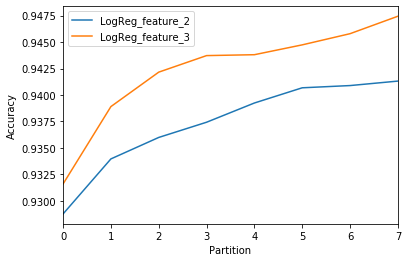

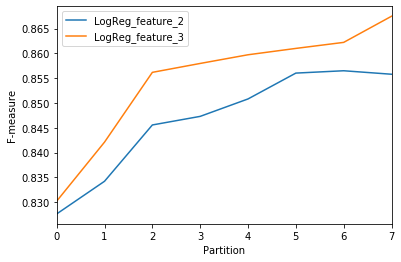

In [40]:
acc  = pd.DataFrame(accuracy)
fmea = pd.DataFrame(fmeasure)
plot_acc  = acc.plot()
plot_fmea = fmea.plot()


plot_acc.set_ylabel('Accuracy')
plot_fmea.set_ylabel('F-measure')
plot_acc.set_xlabel('Partition')
plot_fmea.set_xlabel('Partition')

plot_acc
plot_fmea

### Exercise 9

In [36]:
sample_size = len(dev_test)
from scipy import stats

bi = stats.binom.ppf([0.025, 0.975], 1000, 0.94)/1000
print(bi)

[0.925 0.954]


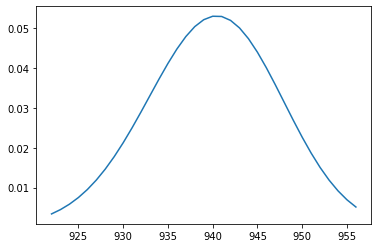

In [37]:
import matplotlib.pyplot as plt
x=np.arange(stats.binom.ppf(0.01, 1000, 0.94),
               stats.binom.ppf(0.99, 1000, 0.94))
plt.plot(x, stats.binom.pmf(x, 1000, 0.94))

We can estimate the IOB accuracy for this chunker of the total population with a confidence interval. The interval gives us an estimation for where the true accurcy lies, in our case, with a 95% confidence

### Exercise 10

In [38]:
test_set = conll2000.chunked_sents('test.txt', chunk_types=['NP'])

best_chunker = Chunker(dev_train, tagger=ScikitWordTagger,
                        clf=LogisticRegression(), features=npchunk_features_03)
best_score = best_chunker.evaluate(test_set)

print("LogReg + history npchunk_features_03: \n", best_score)
print(best_score.f_measure())

/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


LogReg + history npchunk_features_03: 
 ChunkParse score:
    IOB Accuracy:  96.5%%
    Precision:     92.0%%
    Recall:        92.0%%
    F-Measure:     92.0%%
0.9201046488227007


In [39]:

best_chunker_2 = Chunker(dev_set, tagger=ScikitWordTagger,
                        clf=LogisticRegression(), features=npchunk_features_03)
best_score_2 = best_chunker_2.evaluate(test_set)

print("LogReg + history npchunk_features_03 on whole dev-set: \n", best_score_2)
print(best_score_2.f_measure())


LogReg + history npchunk_features_03 on whole dev-set: 
 ChunkParse score:
    IOB Accuracy:  96.6%%
    Precision:     92.2%%
    Recall:        92.2%%
    F-Measure:     92.2%%
0.9224328784768345


#### Do you see any changes by including what was earlier dev_test in your training data?
- We can see that including a bigger (~12.6%) test-set gave the chunker about 0.1-0.2% better accuracy and f-score

### Exercise 11

| Manual evaluation | True positive | False Positive | False Negative |
| --- | --- | --- | --- |
| different[3] | 14 | 1 | 0 |
| different[100] | 20 |  | 0 |
| different[550] | 28 | 1 | 0 |
| different[590] | 13 | 0 | 0 |
| different[600] | 24 | 0 | 1 |
| total | 99 | 2 | 1 |

\begin{equation*}
Recall : 99/100 = 0,99
\end{equation*}

\begin{equation*}
Precision : 99/101 = 0,9801980198 ≈ 0.98
\end{equation*}




\begin{equation*}
F-score = 2 *  \frac{Recall * Precision}{Recall + Precision} = 2 * \frac{0,99 * 0,9801980198}{0,99 + 0,9801980198} = 0.98507462686 ≈ 0.985
\end{equation*}